In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import random
import os

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torch.utils.data.dataloader import default_collate
from torch.autograd import Variable
from torchvision import datasets
from tqdm import tqdm

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/CL_experiments_MNIST')
import data
import utils

# from avalanche.benchmarks.classic import SplitMNIST

In [ ]:
# Define relevant variables for the ML task
batch_size = 32
num_class = 10
num_epoch = 20

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# generate permutations for the tasks.
np.random.seed(0)
permutations = [
    np.random.permutation(data.DATASET_CONFIGS['mnist']['size']**2) for
    _ in range(5)
]

# prepare mnist datasets.
train_datasets = [
    data.get_permuted_dataset('mnist', permutation=p) for p in permutations
]
test_datasets = [
    data.get_permuted_dataset('mnist', train=False, permutation=p) for p in permutations
]

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/mnist/MNIST/raw



In [ ]:
# load task-specific training & test dataset - from training_datasets
t_train_loaders = []
t_test_loaders = []
for idx, train_dataset in enumerate(train_datasets, 1):
    print(idx)
    task, dummy = random_split(train_dataset, [12000, len(train_dataset) - 12000])
    t_train, t_test = random_split(task, [int(len(task) * 0.8), len(task) - int(len(task) * 0.8)])
    print('len(t_train): {}'.format(len(t_train)))
    print('len(t_test): {}'.format(len(t_test)))
    t_train_loaders.append(data.get_permuted_data_loader(t_train, batch_size=batch_size))
    t_test_loaders.append(data.get_permuted_data_loader(t_test, batch_size=batch_size))

# load general test dataset - from test_datasets
test_dataset = []
for dataset in test_datasets:
    test_dataset = ConcatDataset([test_dataset, dataset])
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

1
len(t_train): 9600
len(t_test): 2400
2
len(t_train): 9600
len(t_test): 2400
3
len(t_train): 9600
len(t_test): 2400
4
len(t_train): 9600
len(t_test): 2400
5
len(t_train): 9600
len(t_test): 2400


In [ ]:
# Check Data Shape
# Check # of samples in each set
data.data_size_check(t_train_loaders, "task-specific train")
data.data_size_check(t_test_loaders, "task-specific test")
data.data_size_check([test_loader], "Overall test")

Data size check of task-specific train DataLoaders
Task_1:
t1_task-specific train:
# of samples: 9600
data size: torch.Size([32, 1, 784])
data[0] size: torch.Size([1, 784])
labels size: torch.Size([32])

Task_2:
t2_task-specific train:
# of samples: 9600
data size: torch.Size([32, 1, 784])
data[0] size: torch.Size([1, 784])
labels size: torch.Size([32])

Task_3:
t3_task-specific train:
# of samples: 9600
data size: torch.Size([32, 1, 784])
data[0] size: torch.Size([1, 784])
labels size: torch.Size([32])

Task_4:
t4_task-specific train:
# of samples: 9600
data size: torch.Size([32, 1, 784])
data[0] size: torch.Size([1, 784])
labels size: torch.Size([32])

Task_5:
t5_task-specific train:
# of samples: 9600
data size: torch.Size([32, 1, 784])
data[0] size: torch.Size([1, 784])
labels size: torch.Size([32])

------\--------
Data size check of task-specific test DataLoaders
Task_1:
t1_task-specific test:
# of samples: 2400
data size: torch.Size([32, 1, 784])
data[0] size: torch.Size([1, 784

Model

In [ ]:
# model = utils.CNN(num_class).to(device)
model = utils.MLP(input_size=28*28, output_size=10, hidden_dropout=True, input_dropout=True).to(device)

#Use SGD, learning rate=0.001
learning_rate = 0.001
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)
ewc_sample_size = 1000
ewc_lambda = 40

Training & Evaluation

In [ ]:
train_ac_list = []

t1_test_ac_list = []
t2_test_ac_list = []
t3_test_ac_list = []
t4_test_ac_list = []
t5_test_ac_list = []
task_ac_list = np.zeros((5,6)).tolist()

test_ac_list = []

Period 1 - pretrained: [None] training [t1_train], testing [t1_test]

In [ ]:
print("Period 1 training")
for epoch in range(num_epoch):
    train_ac_list = utils.training(model, optimizer, t_train_loaders[0], train_ac_list, epoch, task_idx=1)

    t1_test_ac_list = utils.testing(model, t_test_loaders[0], t1_test_ac_list, epoch, task_idx=1)
    
    if (epoch+1)%5 == 0:
        print('-------------------------------------------------------------------')

print()
test_ac_list = utils.testing(model, test_loader, test_ac_list, epoch=0, task_idx=0)

task_ac_list[0][0] = t1_test_ac_list[-1]  # task-specific test accuracy

Period 1 training
Epoch_5: task_1 Train_Acc: 0.8449
Epoch_5: task_1 Test_Acc: 0.8954
-------------------------------------------------------------------
Epoch_10: task_1 Train_Acc: 0.9105
Epoch_10: task_1 Test_Acc: 0.9233
-------------------------------------------------------------------
Epoch_15: task_1 Train_Acc: 0.9396
Epoch_15: task_1 Test_Acc: 0.9387
-------------------------------------------------------------------
Epoch_20: task_1 Train_Acc: 0.9498
Epoch_20: task_1 Test_Acc: 0.9487
-------------------------------------------------------------------

Epoch_1: Overall Test_Acc: 0.2747


Period 2 - pretrained: [t1_train] training [t2_train], testing [t1_test, t2_test]

In [ ]:
# ewc moskomule version code
"""
old_tasks = []
images_t1 = list(map(lambda x: x[0], t_train_loaders[0].dataset))
old_tasks = old_tasks + random.sample(images_t1, k=ewc_sample_size)
old_tasks = random.sample(old_tasks, k=ewc_sample_size)
ewc = utils.EWC(model, old_tasks)
"""
# ewc fisher information matrix print out
"""
print("FIM ewc")
ewc.debugPrint()
print("")
print("FIM ewc_h")
ewc_h.debugPrint()
"""

'\nprint("FIM ewc")\newc.debugPrint()\nprint("")\nprint("FIM ewc_h")\newc_h.debugPrint()\n'

In [ ]:
print("Period 2 training")
# Consolidate model with parameters from the prior task learning
ewc_h = utils.EWC_H(model, t_train_loaders[0], batch_size=batch_size, sample_size=ewc_sample_size)

for epoch in range(num_epoch):
    train_ac_list = utils.training_ewc(model, ewc_h, ewc_lambda, optimizer, t_train_loaders[1], train_ac_list, epoch, task_idx=2)

    t1_test_ac_list = utils.testing(model, t_test_loaders[0], t1_test_ac_list, epoch, task_idx=1)
    t2_test_ac_list = utils.testing(model, t_test_loaders[1], t2_test_ac_list, epoch, task_idx=2)
    
    if (epoch+1)%5 == 0:
        print('-------------------------------------------------------------------')

print()
test_ac_list = utils.testing(model, test_loader, test_ac_list, epoch=0, task_idx=0)

task_ac_list[0][1] = t1_test_ac_list[-1]  # task-specific test accuracy
task_ac_list[1][1] = t2_test_ac_list[-1]

Period 2 training
Epoch_5: task_2 Train_Acc: 0.9275
Epoch_5: task_1 Test_Acc: 0.9413
Epoch_5: task_2 Test_Acc: 0.9337
-------------------------------------------------------------------
Epoch_10: task_2 Train_Acc: 0.9499
Epoch_10: task_1 Test_Acc: 0.9337
Epoch_10: task_2 Test_Acc: 0.9479
-------------------------------------------------------------------
Epoch_15: task_2 Train_Acc: 0.9609
Epoch_15: task_1 Test_Acc: 0.9333
Epoch_15: task_2 Test_Acc: 0.9525
-------------------------------------------------------------------
Epoch_20: task_2 Train_Acc: 0.9673
Epoch_20: task_1 Test_Acc: 0.9333
Epoch_20: task_2 Test_Acc: 0.9550
-------------------------------------------------------------------

Epoch_1: Overall Test_Acc: 0.4591


Period 3 - pretrained: [t1_train, t2_train] training [t3_train], testing [t1_test, t2_test, t3_test]

In [ ]:
print("Period 3 training")
# Consolidate model with parameters from the prior task learning
ewc_h = utils.EWC_H(model, t_train_loaders[1], batch_size=batch_size, sample_size=ewc_sample_size)

for epoch in range(num_epoch):
    train_ac_list = utils.training_ewc(model, ewc_h, ewc_lambda, optimizer, t_train_loaders[2], train_ac_list, epoch, task_idx=3)

    t1_test_ac_list = utils.testing(model, t_test_loaders[0], t1_test_ac_list, epoch, task_idx=1)
    t2_test_ac_list = utils.testing(model, t_test_loaders[1], t2_test_ac_list, epoch, task_idx=2)
    t3_test_ac_list = utils.testing(model, t_test_loaders[2], t3_test_ac_list, epoch, task_idx=3)

    if (epoch+1)%5 == 0:
        print('-------------------------------------------------------------------')

print()
test_ac_list = utils.testing(model, test_loader, test_ac_list, epoch=0, task_idx=0)

task_ac_list[0][2] = t1_test_ac_list[-1]  # task-specific test accuracy
task_ac_list[1][2] = t2_test_ac_list[-1]
task_ac_list[2][2] = t3_test_ac_list[-1]

Period 3 training
Epoch_5: task_3 Train_Acc: 0.9437
Epoch_5: task_1 Test_Acc: 0.9137
Epoch_5: task_2 Test_Acc: 0.9475
Epoch_5: task_3 Test_Acc: 0.9446
-------------------------------------------------------------------
Epoch_10: task_3 Train_Acc: 0.9619
Epoch_10: task_1 Test_Acc: 0.9046
Epoch_10: task_2 Test_Acc: 0.9529
Epoch_10: task_3 Test_Acc: 0.9500
-------------------------------------------------------------------
Epoch_15: task_3 Train_Acc: 0.9727
Epoch_15: task_1 Test_Acc: 0.8988
Epoch_15: task_2 Test_Acc: 0.9513
Epoch_15: task_3 Test_Acc: 0.9546
-------------------------------------------------------------------
Epoch_20: task_3 Train_Acc: 0.9758
Epoch_20: task_1 Test_Acc: 0.8875
Epoch_20: task_2 Test_Acc: 0.9487
Epoch_20: task_3 Test_Acc: 0.9583
-------------------------------------------------------------------

Epoch_1: Overall Test_Acc: 0.5952


Period 4 - pretrained: [t1_train, t2_train, t3_train] training [t4_train], testing [t1_test, t2_test, t3_train, t4_train]

In [ ]:
print("Period 4 training")
# Consolidate model with parameters from the prior task learning
ewc_h = utils.EWC_H(model, t_train_loaders[2], batch_size=batch_size, sample_size=ewc_sample_size)

for epoch in range(num_epoch):
    train_ac_list = utils.training_ewc(model, ewc_h, ewc_lambda, optimizer, t_train_loaders[3], train_ac_list, epoch, task_idx=4)

    t1_test_ac_list = utils.testing(model, t_test_loaders[0], t1_test_ac_list, epoch, task_idx=1)
    t2_test_ac_list = utils.testing(model, t_test_loaders[1], t2_test_ac_list, epoch, task_idx=2)
    t3_test_ac_list = utils.testing(model, t_test_loaders[2], t3_test_ac_list, epoch, task_idx=3)
    t4_test_ac_list = utils.testing(model, t_test_loaders[3], t4_test_ac_list, epoch, task_idx=4)

    if (epoch+1)%5 == 0:
        print('-------------------------------------------------------------------')

print()
test_ac_list = utils.testing(model, test_loader, test_ac_list, epoch=0, task_idx=0)

task_ac_list[0][3] = t1_test_ac_list[-1]  # task-specific test accuracy
task_ac_list[1][3] = t2_test_ac_list[-1]
task_ac_list[2][3] = t3_test_ac_list[-1]
task_ac_list[3][3] = t4_test_ac_list[-1]

Period 4 training
Epoch_5: task_4 Train_Acc: 0.9474
Epoch_5: task_1 Test_Acc: 0.7567
Epoch_5: task_2 Test_Acc: 0.9038
Epoch_5: task_3 Test_Acc: 0.9313
Epoch_5: task_4 Test_Acc: 0.9483
-------------------------------------------------------------------
Epoch_10: task_4 Train_Acc: 0.9667
Epoch_10: task_1 Test_Acc: 0.7125
Epoch_10: task_2 Test_Acc: 0.8846
Epoch_10: task_3 Test_Acc: 0.9263
Epoch_10: task_4 Test_Acc: 0.9546
-------------------------------------------------------------------
Epoch_15: task_4 Train_Acc: 0.9783
Epoch_15: task_1 Test_Acc: 0.6904
Epoch_15: task_2 Test_Acc: 0.8671
Epoch_15: task_3 Test_Acc: 0.9187
Epoch_15: task_4 Test_Acc: 0.9546
-------------------------------------------------------------------
Epoch_20: task_4 Train_Acc: 0.9812
Epoch_20: task_1 Test_Acc: 0.6692
Epoch_20: task_2 Test_Acc: 0.8567
Epoch_20: task_3 Test_Acc: 0.9121
Epoch_20: task_4 Test_Acc: 0.9583
-------------------------------------------------------------------

Epoch_1: Overall Test_Acc: 0.7

Period 5 - pretrained: [t1_train, t2_train, t3_train, t4_train] training [t5_train], testing [t1_test, t2_test, t3_train, t4_train, t5_train]

In [ ]:
print("Period 5 training")
# Consolidate model with parameters from the prior task learning
ewc_h = utils.EWC_H(model, t_train_loaders[3], batch_size=batch_size, sample_size=ewc_sample_size)

for epoch in range(num_epoch):
    train_ac_list = utils.training_ewc(model, ewc_h, ewc_lambda, optimizer, t_train_loaders[4], train_ac_list, epoch, task_idx=5)

    t1_test_ac_list = utils.testing(model, t_test_loaders[0], t1_test_ac_list, epoch, task_idx=1)
    t2_test_ac_list = utils.testing(model, t_test_loaders[1], t2_test_ac_list, epoch, task_idx=2)
    t3_test_ac_list = utils.testing(model, t_test_loaders[2], t3_test_ac_list, epoch, task_idx=3)
    t4_test_ac_list = utils.testing(model, t_test_loaders[3], t4_test_ac_list, epoch, task_idx=4)
    t5_test_ac_list = utils.testing(model, t_test_loaders[4], t5_test_ac_list, epoch, task_idx=5)

    if (epoch+1)%5 == 0:
        print('-------------------------------------------------------------------')

print()
test_ac_list = utils.testing(model, test_loader, test_ac_list, epoch=0, task_idx=0)

task_ac_list[0][4] = t1_test_ac_list[-1]  # task-specific test accuracy
task_ac_list[1][4] = t2_test_ac_list[-1]
task_ac_list[2][4] = t3_test_ac_list[-1]
task_ac_list[3][4] = t4_test_ac_list[-1]
task_ac_list[4][4] = t5_test_ac_list[-1]

Period 5 training
Epoch_5: task_5 Train_Acc: 0.9524
Epoch_5: task_1 Test_Acc: 0.7025
Epoch_5: task_2 Test_Acc: 0.8804
Epoch_5: task_3 Test_Acc: 0.8538
Epoch_5: task_4 Test_Acc: 0.9396
Epoch_5: task_5 Test_Acc: 0.9446
-------------------------------------------------------------------
Epoch_10: task_5 Train_Acc: 0.9686
Epoch_10: task_1 Test_Acc: 0.6562
Epoch_10: task_2 Test_Acc: 0.8583
Epoch_10: task_3 Test_Acc: 0.8429
Epoch_10: task_4 Test_Acc: 0.9254
Epoch_10: task_5 Test_Acc: 0.9554
-------------------------------------------------------------------
Epoch_15: task_5 Train_Acc: 0.9780
Epoch_15: task_1 Test_Acc: 0.6125
Epoch_15: task_2 Test_Acc: 0.8233
Epoch_15: task_3 Test_Acc: 0.8433
Epoch_15: task_4 Test_Acc: 0.9192
Epoch_15: task_5 Test_Acc: 0.9587
-------------------------------------------------------------------
Epoch_20: task_5 Train_Acc: 0.9808
Epoch_20: task_1 Test_Acc: 0.5537
Epoch_20: task_2 Test_Acc: 0.7867
Epoch_20: task_3 Test_Acc: 0.8300
Epoch_20: task_4 Test_Acc: 0.919

Visualize results

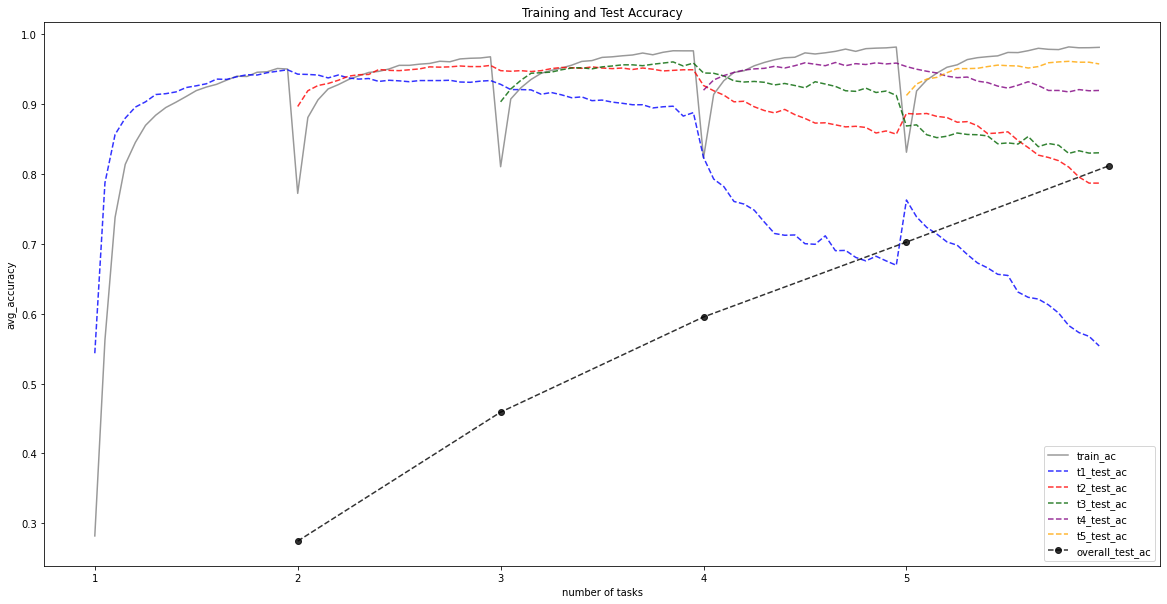

In [ ]:
#Plot - use all data in test accuracy of each task
plt.figure(figsize=[20,10])
plt.plot(np.arange(0, int(5*num_epoch)), train_ac_list, color='grey', linestyle='-', label='train_ac', alpha=0.8)
plt.plot(np.arange(0, int(5*num_epoch)), t1_test_ac_list, color='blue', linestyle='--', label='t1_test_ac', alpha=0.8)
plt.plot(np.arange(int(1*num_epoch), int(5*num_epoch)), t2_test_ac_list, color='red', linestyle='--', label='t2_test_ac', alpha=0.8)
plt.plot(np.arange(int(2*num_epoch), int(5*num_epoch)), t3_test_ac_list, color='darkgreen', linestyle='--', label='t3_test_ac', alpha=0.8)
plt.plot(np.arange(int(3*num_epoch), int(5*num_epoch)), t4_test_ac_list, color='purple', linestyle='--', label='t4_test_ac', alpha=0.8)
plt.plot(np.arange(int(4*num_epoch), int(5*num_epoch)), t5_test_ac_list, color='orange', linestyle='--', label='t5_test_ac', alpha=0.8)
plt.plot([20, 40, 60, 80, 100], test_ac_list, color='black', marker='o', linestyle='--', label='overall_test_ac', alpha=0.8)
plt.legend()
plt.title("Training and Test Accuracy")
plt.xlabel("number of tasks")
plt.ylabel("avg_accuracy")
plt.xticks([0, 20, 40, 60, 80],[1, 2, 3, 4, 5])
plt.show()

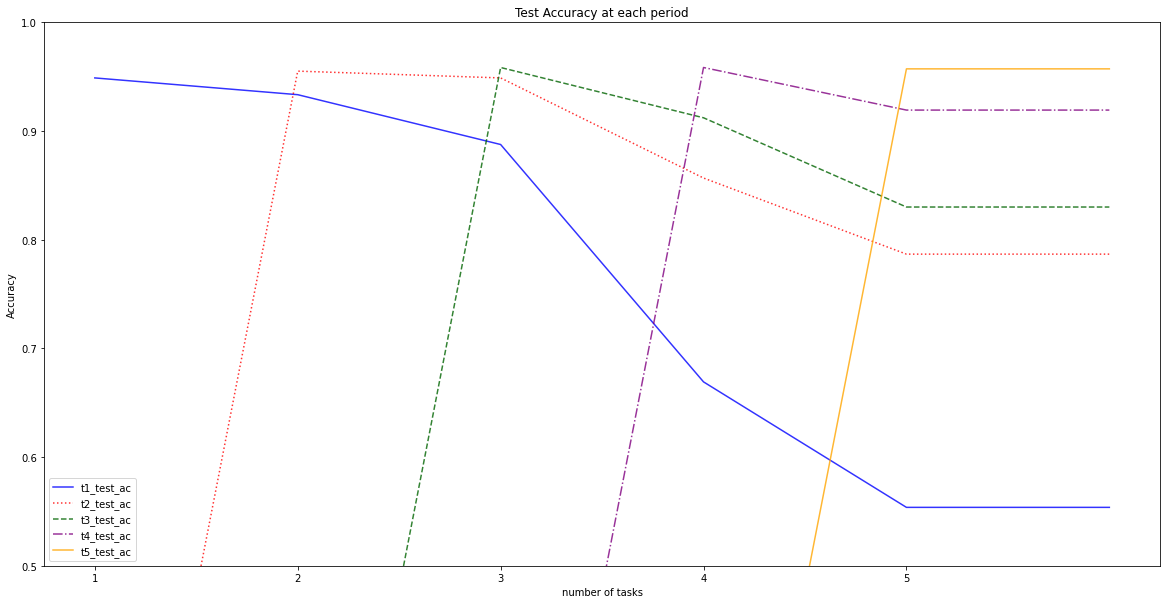

In [ ]:
#Plot - average accuracy of each task
for i in range(5):
  task_ac_list[i][5] = task_ac_list[i][4]

plt.figure(figsize=[20,10])
plt.plot(np.arange(1, 7), task_ac_list[0], color='blue', linestyle='solid', label='t1_test_ac', alpha=0.8)
plt.plot(np.arange(1, 7), task_ac_list[1], color='red', linestyle='dotted', label='t2_test_ac', alpha=0.8)
plt.plot(np.arange(1, 7), task_ac_list[2], color='darkgreen', linestyle='dashed', label='t3_test_ac', alpha=0.8)
plt.plot(np.arange(1, 7), task_ac_list[3], color='purple', linestyle='dashdot', label='t4_test_ac', alpha=0.8)
plt.plot(np.arange(1, 7), task_ac_list[4], color='orange', linestyle='solid', label='t5_test_ac', alpha=0.8)
plt.legend()
plt.title("Test Accuracy at each period")
plt.xlabel("number of tasks")
plt.ylabel("Accuracy")
plt.xticks([1, 2, 3, 4, 5])
plt.ylim([0.5, 1])
plt.show()



Predict 



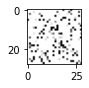

true_label: 3, y_pred: 5



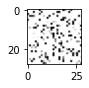

true_label: 0, y_pred: 3



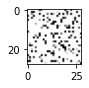

true_label: 8, y_pred: 8



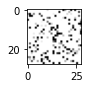

true_label: 3, y_pred: 3



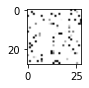

true_label: 1, y_pred: 1



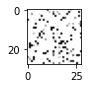

true_label: 3, y_pred: 3



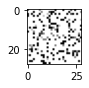

true_label: 9, y_pred: 9



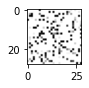

true_label: 3, y_pred: 3



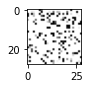

true_label: 9, y_pred: 4



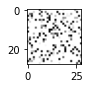

true_label: 3, y_pred: 5



In [ ]:
#Predict Sample 10 examples from MNIST
print("\nPredict \n")
idx = np.random.choice(10000, 10, True)

for i in idx:
    image = test_loader.dataset[i][0].reshape(1, 1, 28*28).float()
    output = model(image.to(device))
    y_pred = torch.argmax(output, dim=1)
    
    plt.figure(figsize=(1, 1))
    plt.imshow(test_loader.dataset[i][0].reshape(28,28), cmap=plt.cm.gray_r)
    plt.show()
    print("true_label: {}, y_pred: {}\n".format(test_loader.dataset[i][1], y_pred[0]))
